<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_VGG19_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 18 18:57:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   33C    P0    28W / 165W |      9MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6244962079799734
GPU (s):
0.030942181998398155
GPU speedup over CPU: 20x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(convert_color, original=False, preprocess=False):

  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.vgg19.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.vgg19.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
58900480/58889256 [==============================] - 46s 1us/step
Using the original RGB and preprocessing
Epoch 1/100
360/360 [==============================] - 18s 42ms/step - loss: 1.1517 - accuracy: 0.6507 - val_loss: 0.6120 - val_accuracy: 0.7336
Epoch 2/100
360/360 [==============================] - 16s 44ms/step - loss: 0.6408 - accuracy: 0.7267 - val_loss: 0.5363 - val_accuracy: 0.7581
Epoch 3/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5981 - accuracy: 0.7433 - val_loss: 0.5600 - val_accuracy: 0.7619
Epoch 4/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5682 - accuracy: 0.7515 - val_loss: 0.5167 - val_accuracy: 0.7742
Epoch 5/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5525 - accuracy: 0.7619 - val_loss: 0.5414 - val_accuracy: 0.7676
Epoch 6/100
360/360

360/360 [==============================] - 13s 37ms/step - loss: 0.3961 - accuracy: 0.8365 - val_loss: 0.4092 - val_accuracy: 0.8383
Epoch 55/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3950 - accuracy: 0.8374 - val_loss: 0.4006 - val_accuracy: 0.8416
Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3907 - accuracy: 0.8380 - val_loss: 0.4081 - val_accuracy: 0.8373
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4014 - accuracy: 0.8353 - val_loss: 0.4268 - val_accuracy: 0.8279
Epoch 58/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3956 - accuracy: 0.8371 - val_loss: 0.4188 - val_accuracy: 0.8374
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3874 - accuracy: 0.8393 - val_loss: 0.4120 - val_accuracy: 0.8336
Epoch 60/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3885 - accuracy: 0.8379 - val_loss: 0.4185 - val_accuracy

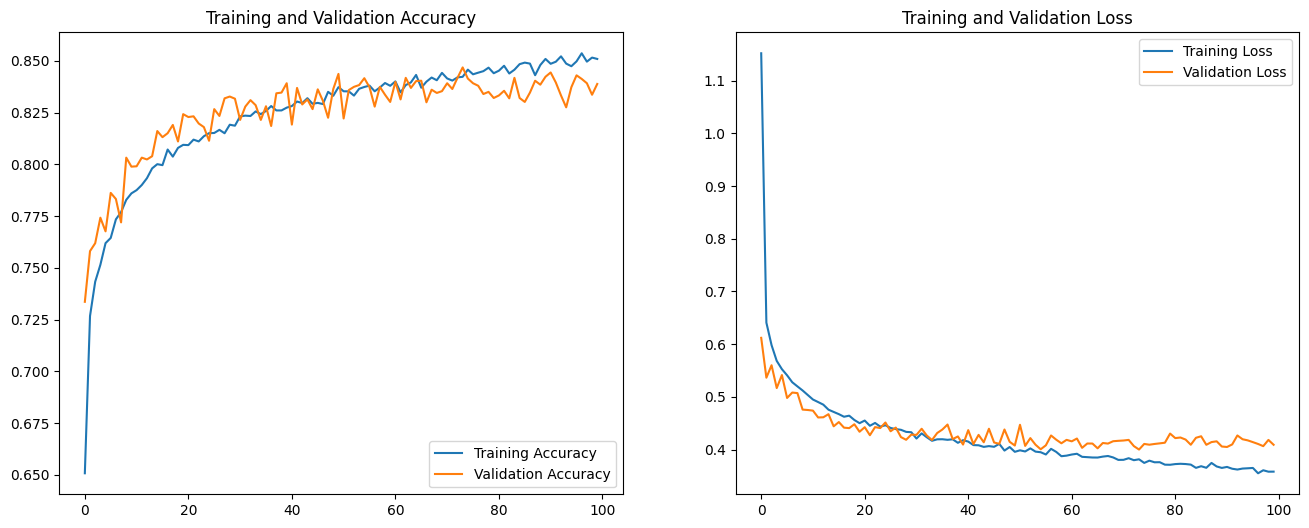

In [5]:
res_rgb = train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 17s 40ms/step - loss: 0.9803 - accuracy: 0.6526 - val_loss: 0.5979 - val_accuracy: 0.7478
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6638 - accuracy: 0.7199 - val_loss: 0.5667 - val_accuracy: 0.7619
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6168 - accuracy: 0.7392 - val_loss: 0.5655 - val_accuracy: 0.7527
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6024 - accuracy: 0.7458 - val_loss: 0.5374 - val_accuracy: 0.7721
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5836 - accuracy: 0.7514 - val_loss: 0.5208 - val_accuracy: 0.7850
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4410 - accuracy: 0.8217 - val_loss: 0.4588 - val_accuracy: 0.8100
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4490 - accuracy: 0.8126 - val_loss: 0.4712 - val_accuracy: 0.8064
Epoch 58/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4420 - accuracy: 0.8179 - val_loss: 0.4437 - val_accuracy: 0.8225
Epoch 59/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4477 - accuracy: 0.8143 - val_loss: 0.4498 - val_accuracy: 0.8192
Epoch 60/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4372 - accuracy: 0.8198 - val_loss: 0.4625 - val_accuracy: 0.8069
Epoch 61/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4361 - accuracy: 0.8221 - val_loss: 0.4565 - val_accuracy: 0.8178
Epoch 62/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4396 - accuracy: 0.8202 - val_loss: 0.4575 -

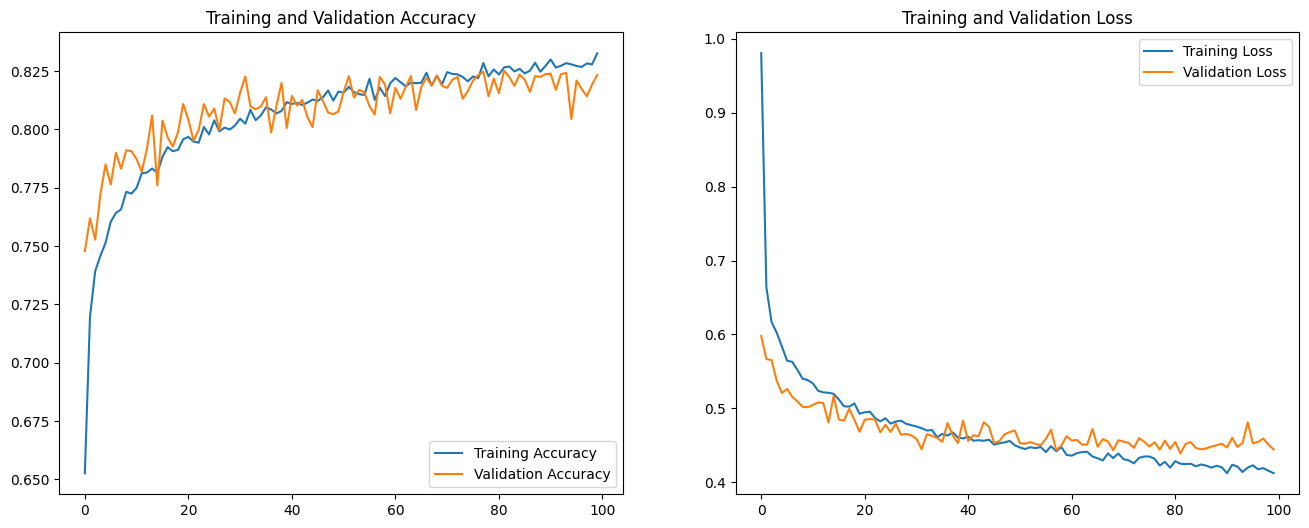

In [6]:
res_lab_pre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 16s 39ms/step - loss: 0.8915 - accuracy: 0.6462 - val_loss: 0.6534 - val_accuracy: 0.7228
Epoch 2/100
360/360 [==============================] - 14s 39ms/step - loss: 0.6954 - accuracy: 0.7021 - val_loss: 0.6066 - val_accuracy: 0.7492
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6516 - accuracy: 0.7274 - val_loss: 0.5942 - val_accuracy: 0.7525
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6306 - accuracy: 0.7352 - val_loss: 0.5652 - val_accuracy: 0.7692
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6050 - accuracy: 0.7463 - val_loss: 0.5454 - val_accuracy: 0.7756
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5879 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4556 - accuracy: 0.8184 - val_loss: 0.4375 - val_accuracy: 0.8239
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4559 - accuracy: 0.8164 - val_loss: 0.4480 - val_accuracy: 0.8204
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4572 - accuracy: 0.8142 - val_loss: 0.4564 - val_accuracy: 0.8112
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4583 - accuracy: 0.8165 - val_loss: 0.4366 - val_accuracy: 0.8282
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4548 - accuracy: 0.8149 - val_loss: 0.4398 - val_accuracy: 0.8265
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4500 - accuracy: 0.8175 - val_loss: 0.4445 - val_accuracy: 0.8241
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4518 - accuracy: 0.8190 - val_loss: 0.4350 -

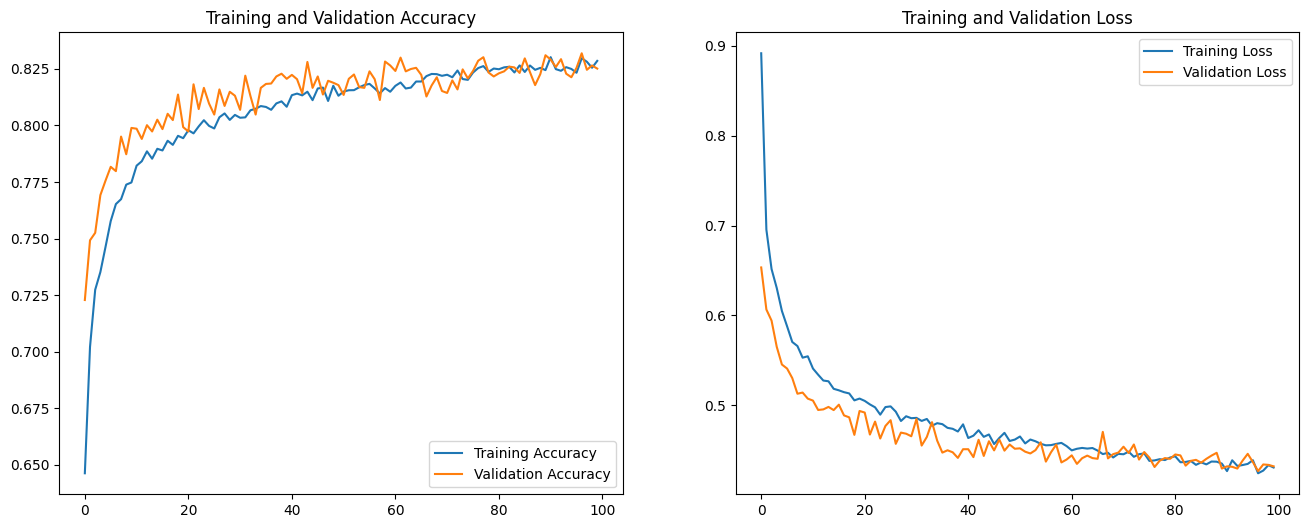

In [7]:
res_lab_nonpre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 38ms/step - loss: 1.6833 - accuracy: 0.2771 - val_loss: 1.4249 - val_accuracy: 0.2890
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4330 - accuracy: 0.2865 - val_loss: 1.4135 - val_accuracy: 0.2746
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4275 - accuracy: 0.2834 - val_loss: 1.4126 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4261 - accuracy: 0.2892 - val_loss: 1.4140 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4255 - accuracy: 0.2902 - val_loss: 1.4174 - val_accuracy: 0.2860
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 1.

Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4227 - accuracy: 0.2939 - val_loss: 1.4132 - val_accuracy: 0.2860
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4227 - accuracy: 0.2942 - val_loss: 1.4126 - val_accuracy: 0.2860
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4227 - accuracy: 0.2913 - val_loss: 1.4138 - val_accuracy: 0.2860
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4226 - accuracy: 0.2923 - val_loss: 1.4158 - val_accuracy: 0.2860
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4230 - accuracy: 0.2929 - val_loss: 1.4144 - val_accuracy: 0.2860
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4224 - accuracy: 0.2930 - val_loss: 1.4130 - val_accuracy: 0.2860
Epoch 63/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4228 - accuracy: 0.2935 - val_loss: 1.4137 -

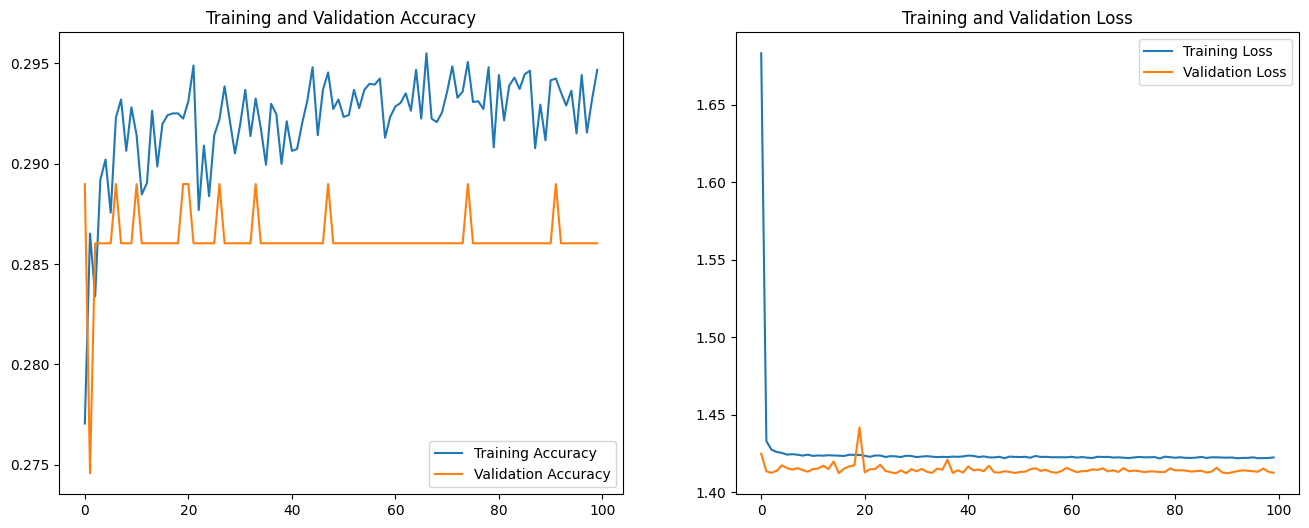

In [8]:
res_xyz_pre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 16s 39ms/step - loss: 1.0469 - accuracy: 0.5315 - val_loss: 0.9052 - val_accuracy: 0.6113
Epoch 2/100
360/360 [==============================] - 15s 40ms/step - loss: 0.8911 - accuracy: 0.6124 - val_loss: 0.7899 - val_accuracy: 0.6686
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8526 - accuracy: 0.6315 - val_loss: 0.8197 - val_accuracy: 0.6539
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8256 - accuracy: 0.6457 - val_loss: 0.7411 - val_accuracy: 0.6735
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8149 - accuracy: 0.6456 - val_loss: 0.8184 - val_accuracy: 0.6219
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.7981 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6630 - accuracy: 0.7216 - val_loss: 0.6409 - val_accuracy: 0.7204
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6580 - accuracy: 0.7270 - val_loss: 0.6030 - val_accuracy: 0.7470
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6622 - accuracy: 0.7223 - val_loss: 0.6177 - val_accuracy: 0.7484
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6550 - accuracy: 0.7254 - val_loss: 0.5921 - val_accuracy: 0.7475
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6557 - accuracy: 0.7256 - val_loss: 0.6020 - val_accuracy: 0.7426
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6569 - accuracy: 0.7276 - val_loss: 0.5916 - val_accuracy: 0.7457
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6575 - accuracy: 0.7246 - val_loss: 0.5877 -

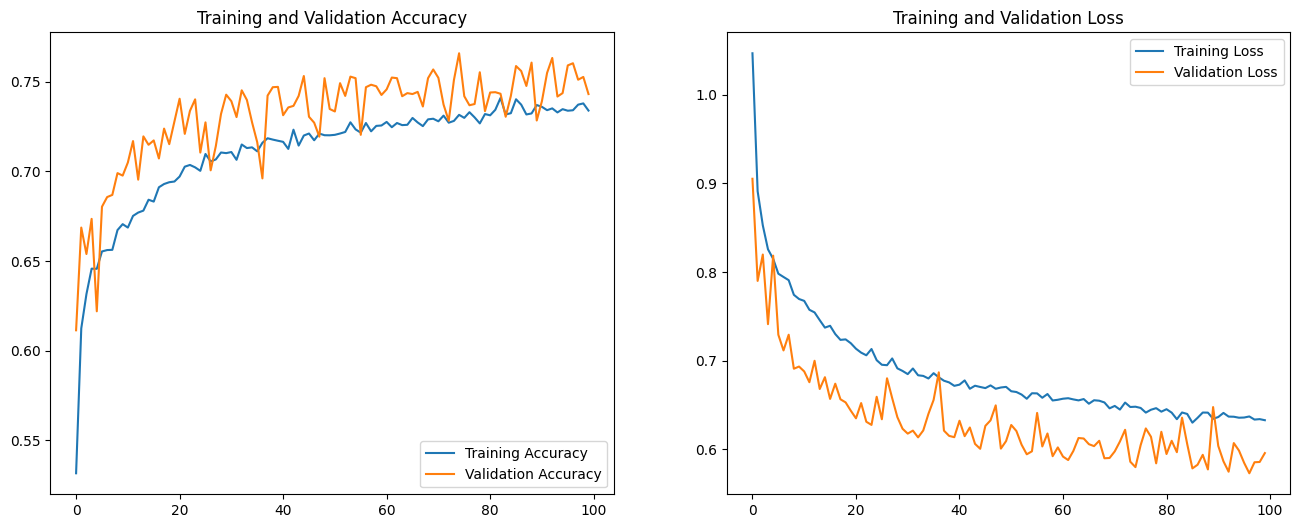

In [9]:
res_xyz_nonpre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 38ms/step - loss: 1.6506 - accuracy: 0.2767 - val_loss: 1.4118 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4301 - accuracy: 0.2854 - val_loss: 1.4132 - val_accuracy: 0.2890
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4256 - accuracy: 0.2901 - val_loss: 1.4193 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4239 - accuracy: 0.2950 - val_loss: 1.4116 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4220 - accuracy: 0.2915 - val_loss: 1.4127 - val_accuracy: 0.2860
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2879 - accuracy: 0.3964 - val_loss: 1.2348 - val_accuracy: 0.4227
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2862 - accuracy: 0.3990 - val_loss: 1.2240 - val_accuracy: 0.4262
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2850 - accuracy: 0.3971 - val_loss: 1.2364 - val_accuracy: 0.4220
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2856 - accuracy: 0.4012 - val_loss: 1.2240 - val_accuracy: 0.4253
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2889 - accuracy: 0.3987 - val_loss: 1.3083 - val_accuracy: 0.3880
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2854 - accuracy: 0.4027 - val_loss: 1.2754 - val_accuracy: 0.4040
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2855 - accuracy: 0.3959 - val_loss: 1.2285 -

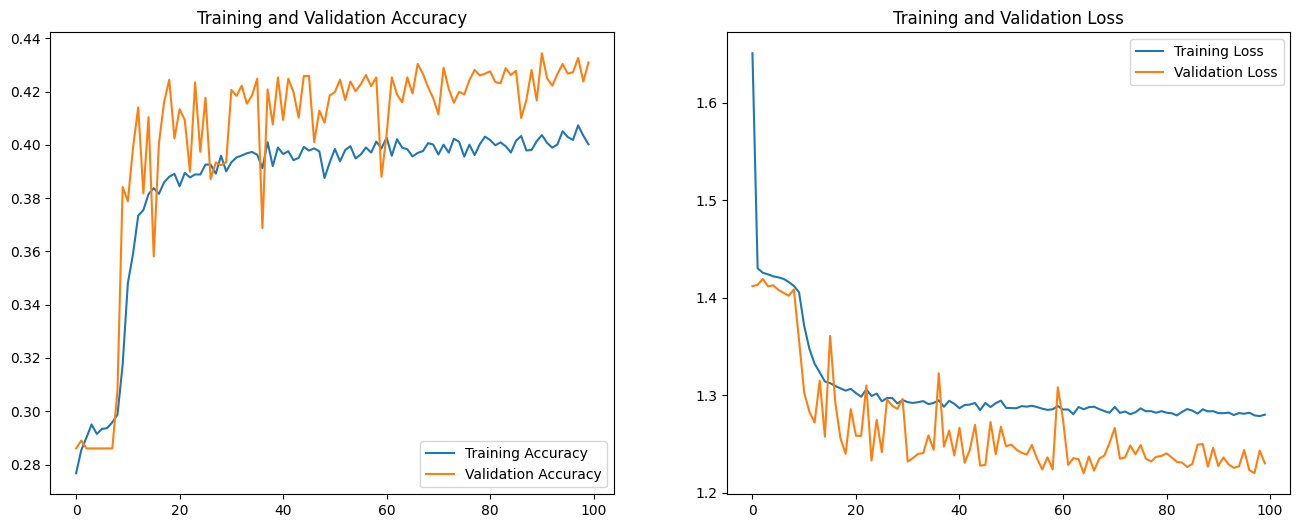

In [10]:
res_hsv_pre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 16s 37ms/step - loss: 0.8625 - accuracy: 0.6251 - val_loss: 0.7488 - val_accuracy: 0.6688
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.7585 - accuracy: 0.6685 - val_loss: 0.7095 - val_accuracy: 0.6794
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.7403 - accuracy: 0.6751 - val_loss: 0.7120 - val_accuracy: 0.6804
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 0.7222 - accuracy: 0.6860 - val_loss: 0.7019 - val_accuracy: 0.6806
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.7195 - accuracy: 0.6872 - val_loss: 0.6897 - val_accuracy: 0.6905
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.7048 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5846 - accuracy: 0.7545 - val_loss: 0.5805 - val_accuracy: 0.7549
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5819 - accuracy: 0.7544 - val_loss: 0.5872 - val_accuracy: 0.7563
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5802 - accuracy: 0.7621 - val_loss: 0.5935 - val_accuracy: 0.7537
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5775 - accuracy: 0.7610 - val_loss: 0.5760 - val_accuracy: 0.7603
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5757 - accuracy: 0.7582 - val_loss: 0.5827 - val_accuracy: 0.7631
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5772 - accuracy: 0.7615 - val_loss: 0.5951 - val_accuracy: 0.7581
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5739 - accuracy: 0.7603 - val_loss: 0.5736 -

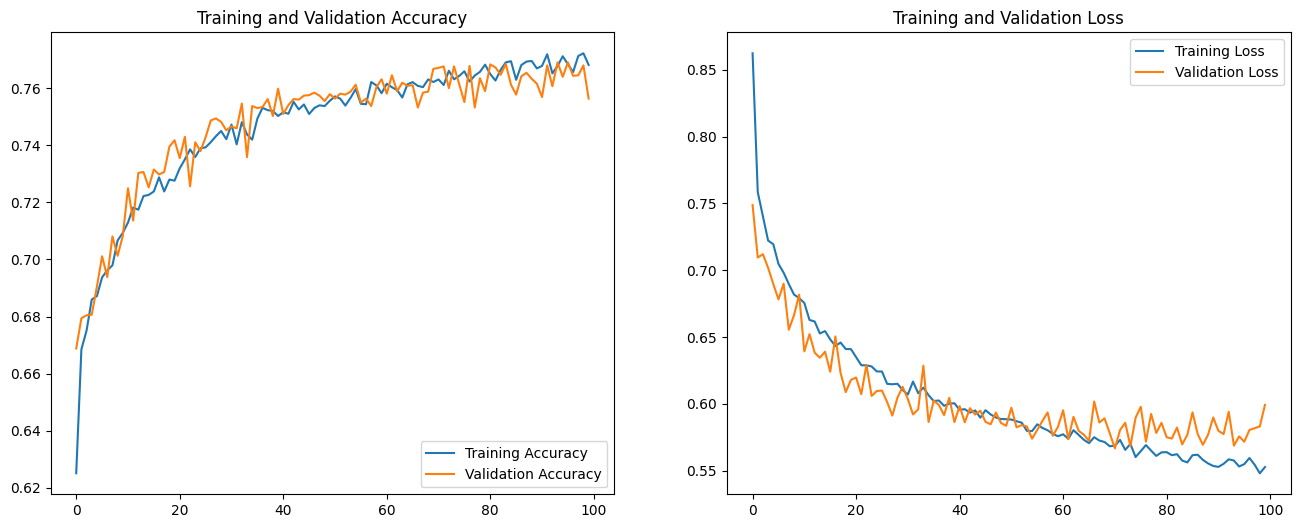

In [11]:
res_hsv_nonpre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 18s 45ms/step - loss: 1.6072 - accuracy: 0.2780 - val_loss: 1.4137 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4365 - accuracy: 0.2843 - val_loss: 1.4146 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4300 - accuracy: 0.2853 - val_loss: 1.4147 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4265 - accuracy: 0.2843 - val_loss: 1.4197 - val_accuracy: 0.2746
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4263 - accuracy: 0.2881 - val_loss: 1.4161 - val_accuracy: 0.2746
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4226 - accuracy: 0.2935 - val_loss: 1.4135 - val_accuracy: 0.2890
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4228 - accuracy: 0.2901 - val_loss: 1.4156 - val_accuracy: 0.2860
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4226 - accuracy: 0.2931 - val_loss: 1.4130 - val_accuracy: 0.2860
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4229 - accuracy: 0.2917 - val_loss: 1.4149 - val_accuracy: 0.2860
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4229 - accuracy: 0.2924 - val_loss: 1.4134 - val_accuracy: 0.2860
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4230 - accuracy: 0.2922 - val_loss: 1.4125 - val_accuracy: 0.2860
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4227 - accuracy: 0.2929 - val_loss: 1.4144 -

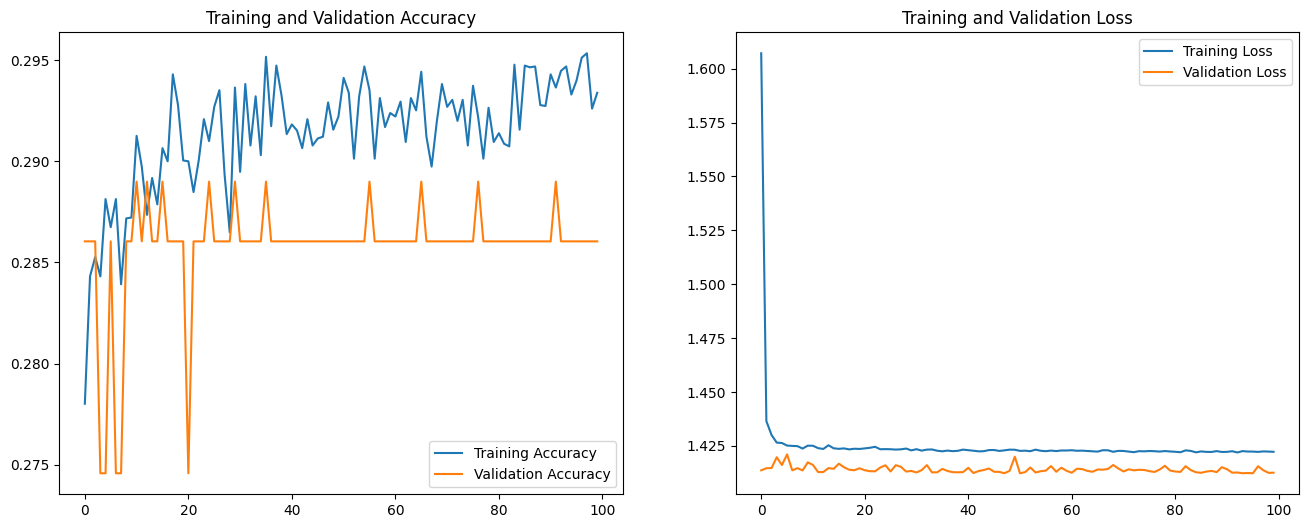

In [12]:
res_yuv_pre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 17s 38ms/step - loss: 1.0819 - accuracy: 0.5023 - val_loss: 0.8355 - val_accuracy: 0.6438
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8959 - accuracy: 0.6048 - val_loss: 0.8186 - val_accuracy: 0.6250
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8456 - accuracy: 0.6313 - val_loss: 0.7813 - val_accuracy: 0.6426
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8259 - accuracy: 0.6397 - val_loss: 0.7368 - val_accuracy: 0.6853
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8118 - accuracy: 0.6482 - val_loss: 0.7213 - val_accuracy: 0.6877
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.7956 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6311 - accuracy: 0.7394 - val_loss: 0.5729 - val_accuracy: 0.7737
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6305 - accuracy: 0.7415 - val_loss: 0.5622 - val_accuracy: 0.7737
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6370 - accuracy: 0.7367 - val_loss: 0.5594 - val_accuracy: 0.7657
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6429 - accuracy: 0.7325 - val_loss: 0.5665 - val_accuracy: 0.7596
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6221 - accuracy: 0.7472 - val_loss: 0.5598 - val_accuracy: 0.7728
Epoch 61/100
360/360 [==============================] - 13s 38ms/step - loss: 0.6342 - accuracy: 0.7413 - val_loss: 0.5565 - val_accuracy: 0.7655
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6254 - accuracy: 0.7437 - val_loss: 0.5816 -

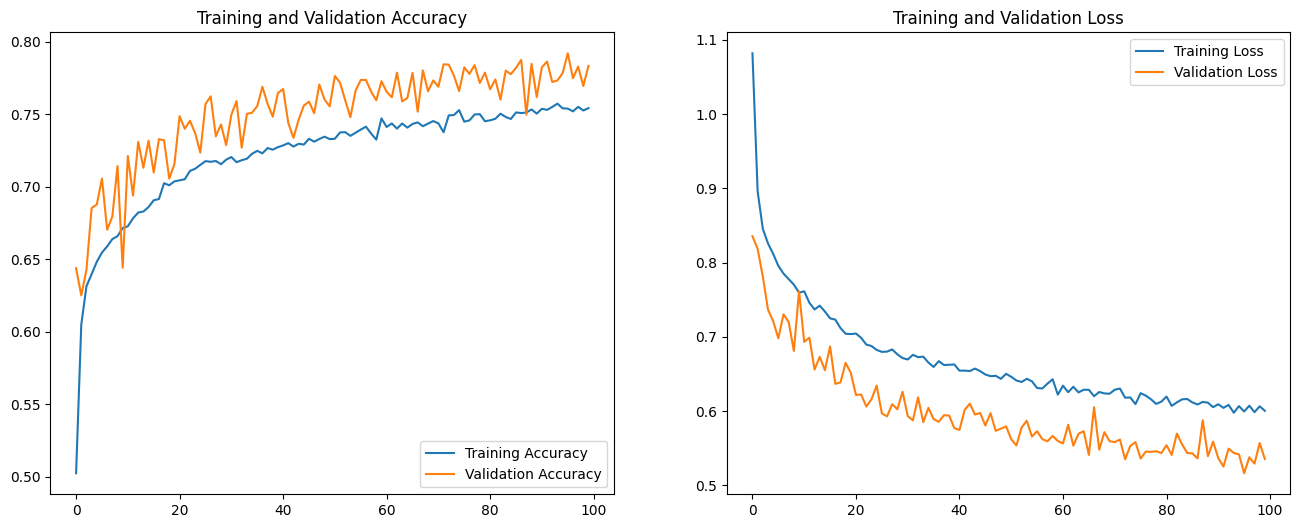

In [13]:
res_yuv_nonpre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 38ms/step - loss: 1.6216 - accuracy: 0.2784 - val_loss: 1.4156 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 14s 39ms/step - loss: 1.4324 - accuracy: 0.2890 - val_loss: 1.4197 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4269 - accuracy: 0.2880 - val_loss: 1.4132 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4246 - accuracy: 0.2870 - val_loss: 1.4130 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4241 - accuracy: 0.2895 - val_loss: 1.4158 - val_accuracy: 0.2860
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4228 - accuracy: 0.2947 - val_loss: 1.4136 - val_accuracy: 0.2860
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4228 - accuracy: 0.2931 - val_loss: 1.4140 - val_accuracy: 0.2860
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4225 - accuracy: 0.2937 - val_loss: 1.4144 - val_accuracy: 0.2860
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4230 - accuracy: 0.2930 - val_loss: 1.4129 - val_accuracy: 0.2890
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4225 - accuracy: 0.2940 - val_loss: 1.4128 - val_accuracy: 0.2890
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4227 - accuracy: 0.2876 - val_loss: 1.4134 - val_accuracy: 0.2860
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4232 - accuracy: 0.2940 - val_loss: 1.4136 -

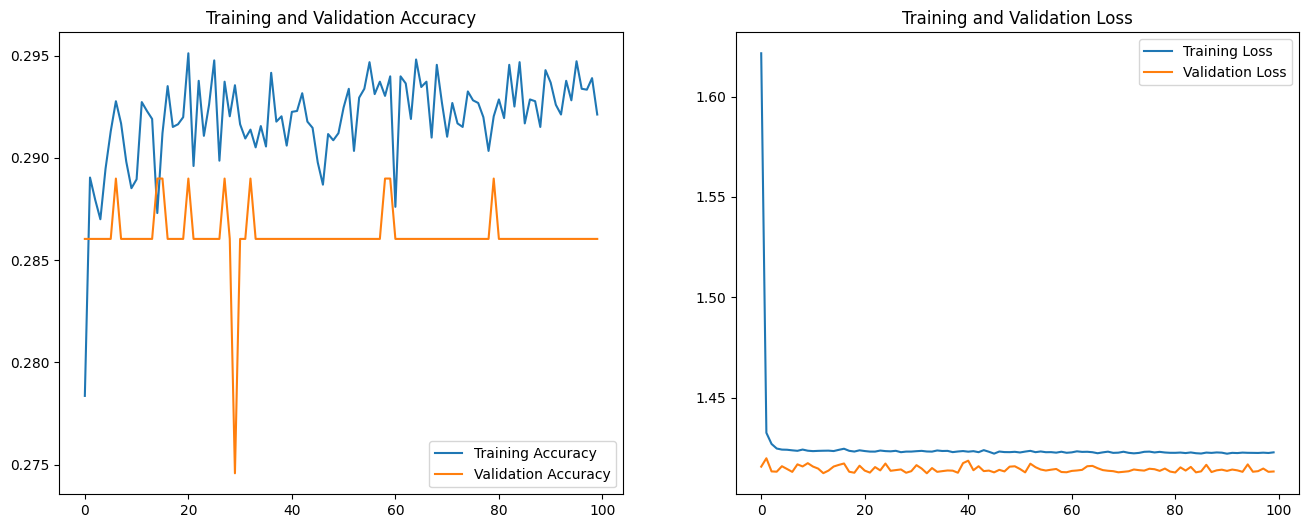

In [14]:
res_ydbdr_pre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 16s 38ms/step - loss: 1.0676 - accuracy: 0.5166 - val_loss: 0.8639 - val_accuracy: 0.6429
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 0.9011 - accuracy: 0.6052 - val_loss: 0.8846 - val_accuracy: 0.6016
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8645 - accuracy: 0.6181 - val_loss: 0.8074 - val_accuracy: 0.6238
Epoch 4/100
360/360 [==============================] - 16s 46ms/step - loss: 0.8472 - accuracy: 0.6277 - val_loss: 0.7623 - val_accuracy: 0.6804
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8234 - accuracy: 0.6429 - val_loss: 0.7865 - val_accuracy: 0.6419
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8216 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6838 - accuracy: 0.7127 - val_loss: 0.6336 - val_accuracy: 0.7331
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6846 - accuracy: 0.7130 - val_loss: 0.6409 - val_accuracy: 0.7273
Epoch 58/100
360/360 [==============================] - 13s 38ms/step - loss: 0.6828 - accuracy: 0.7175 - val_loss: 0.6492 - val_accuracy: 0.7273
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6774 - accuracy: 0.7145 - val_loss: 0.6377 - val_accuracy: 0.7292
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6751 - accuracy: 0.7165 - val_loss: 0.6130 - val_accuracy: 0.7482
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6763 - accuracy: 0.7180 - val_loss: 0.6319 - val_accuracy: 0.7345
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6771 - accuracy: 0.7180 - val_loss: 0.6378 -

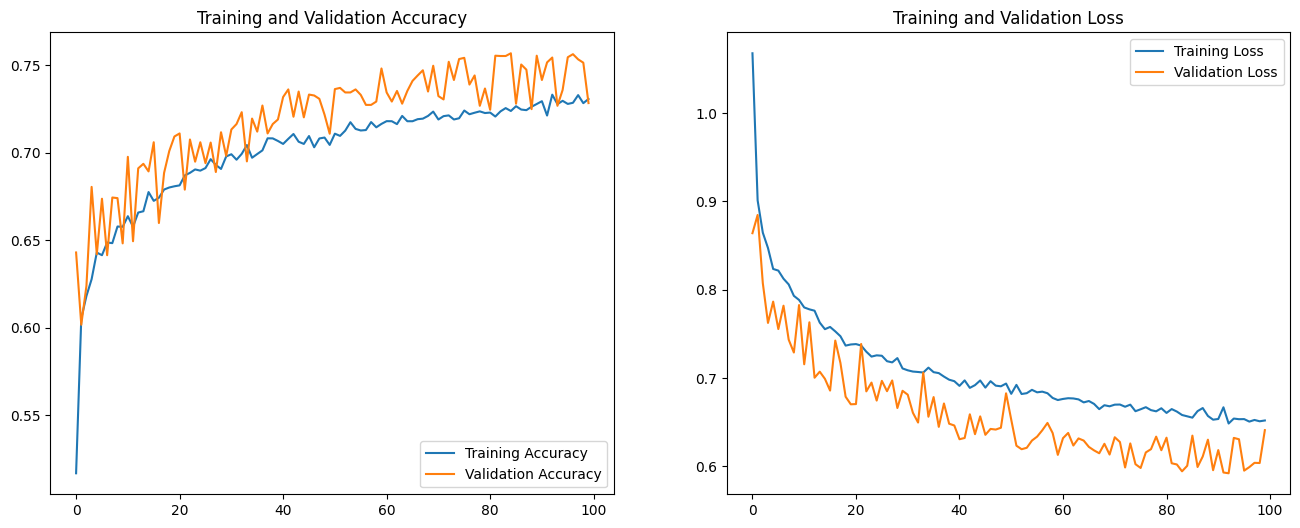

In [15]:
res_ydbdr_nonpre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)

In [16]:
# !mkdir vgg16_nontrainable
# pd.DataFrame(res_rgb).to_csv("vgg16_nontrainable/res_rgb.csv", index=False)
# pd.DataFrame(res_lab_pre).to_csv("vgg16_nontrainable/res_lab_pre.csv", index=False)
# pd.DataFrame(res_lab_nonpre).to_csv("vgg16_nontrainable/res_lab_nonpre.csv", index=False)
# pd.DataFrame(res_xyz_pre).to_csv("vgg16_nontrainable/res_xyz_pre.csv", index=False)
# pd.DataFrame(res_xyz_nonpre).to_csv("vgg16_nontrainable/res_xyz_nonpre.csv", index=False)
# pd.DataFrame(res_hsv_pre).to_csv("vgg16_nontrainable/res_hsv_pre.csv", index=False)
# pd.DataFrame(res_hsv_nonpre).to_csv("vgg16_nontrainable/res_hsv_nonpre.csv", index=False)
# pd.DataFrame(res_yuv_pre).to_csv("vgg16_nontrainable/res_yuv_pre.csv", index=False)
# pd.DataFrame(res_yuv_nonpre).to_csv("vgg16_nontrainable/res_yuv_nonpre.csv", index=False)
# pd.DataFrame(res_ydbdr_pre).to_csv("vgg16_nontrainable/res_ydbdr_pre.csv", index=False)
# pd.DataFrame(res_ydbdr_nonpre).to_csv("vgg16_nontrainable/res_ydbdr_nonpre.csv", index=False)